# Project I (Effective field theory modeling) - Bayesian parameter estimation as part of Chalmers TIF285

by Matthias Hübl & Linus Stach

## Imports, etc.

In [209]:
# Install tqdm and add it to the environment (pip install tqdm). It is not necessary. 
# However, it will give us a nice progress bar!
import tqdm

In [210]:
from quantumsolver import fewnucleonEmulator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator
from scipy import stats
import emcee
import corner

## Task 1

- How dense grid can you use given that each model evaluation takes $\lesssim 1$ ms and you would probably not like to wait more than $\sim$ minutes?

    Assume 1 minute => 60 seconds => 60,000 ms ~ 2^16 => 256x256 dimension

- How many data points would you naively need to infer two model parameters? If you were to combine the data that you have available, which set do you think works best for this inference problem?

    [To be answered]

### Define necessary constants, experimental data, etc.

In [211]:
# Define the size of our mesh
NcD = 256 
NcE = 256
use_large_grid = False

# Other constants
k=3
cbar=1
Q=0.33

The experimental data is obtained from Table I) of the respective paper.

In [212]:
# Experimental data: Mu
mu_E3H=-8.482
mu_E4He=-28.296
mu_Rp4He=1.4552
mu_fT3H=1129.6

# Experimental data: Sigma
sigma_E3H=0.015
sigma_E4He=0.005
sigma_Rp4He=0.0062
sigma_fT3H=3

### Evaluate with quantum solver

Evaluate theoretical values with a quantum solver on a [-2.5, 2.5] X [-1, 1] grid.

In [213]:
# Create a 2-dimensional grid
# cD el [-2.5, 2.5]
# cE el [-1, 1]
cD = np.linspace(start=-2.5, stop=2.5, num=NcD)
cE = np.linspace(start=-1, stop=1, num=NcE)
cD_eval, cE_eval = np.meshgrid(cD,cE)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(fewnucleonEmulator)
E4He_eval, Rp4He_eval, Rch4He_eval, E3He_eval, E3H_eval, E1A3H_eval, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

In [6]:
if use_large_grid:
    NcE = 1028
    NcD = 1028
    cD = np.linspace(start=-2.5, stop=2.5, num=NcD)
    cE = np.linspace(start=-1, stop=1, num=NcE)
    cD_eval, cE_eval = np.meshgrid(cD,cE)
    results = np.load("./pool_outputs.npy")
    E4He_eval = results[:,0].reshape(NcE,NcD)
    Rp4He_eval = results[:,1].reshape(NcE,NcD)
    Rch4He_eval =results[:,2].reshape(NcE,NcD)
    E3He_eval = results[:,3].reshape(NcE,NcD)
    E3H_eval = results[:,4].reshape(NcE,NcD)
    E1A3H_eval = results[:,5].reshape(NcE,NcD)
    fT3H_eval = results[:,6].reshape(NcE,NcD)

### Define bayesian posterior distribution

In [7]:
# --- Prior ---

def prior(cD, cE):
    # cD and cE follow both a normal distribution ~ N(0,5)
    prior_dist = stats.norm(0, 5)  
    p1 = prior_dist.pdf(cD)
    p2 = prior_dist.pdf(cE)
    prior = np.outer(p2, p1)
    return prior

# --- Likelihood ---

def likelihood(data, mu, sigma):
    likelihood_dist = stats.norm(mu, sigma)
    likelihood = likelihood_dist.pdf(data)
    return likelihood

# --- Posterior ---

def posterior(cD, cE, data, mu, sigma, normalized = False):
    p = prior(cD, cE)*likelihood(data, mu, sigma)
    if normalized:
        norm = np.trapz(np.trapz(p, cE, axis=1), cD)
        return p/norm
    return p

### Estimate model discrepancy

In [214]:
# Variance!
disc2_E3H = np.power(mu_E3H*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_E4He = np.power(mu_E4He*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_Rp4He = np.power(mu_Rp4He*cbar*np.power(Q,k+1),2)/(1-(Q**2))
disc2_fT3H = np.power(mu_fT3H*cbar*np.power(Q,k+1),2)/(1-(Q**2))

# square root of sum of squared standard error
sigma_E3H_efterr = np.sqrt((sigma_E3H**2)+disc2_E3H)
sigma_E4He_efterr = np.sqrt((sigma_E4He**2)+disc2_E4He)
sigma_Rp4He_efterr = np.sqrt((sigma_Rp4He**2)+disc2_Rp4He)
sigma_fT3H_efterr = np.sqrt((sigma_fT3H**2)+disc2_fT3H)

### Estimate Posterior

In [215]:
# Posterior without eft error
pE3H_noefterr = posterior(cD, cE, E3H_eval, mu=mu_E3H, sigma=sigma_E3H)
pE4He_noefterr = posterior(cD, cE, E4He_eval, mu=mu_E4He, sigma=sigma_E4He)
pRp4He_noefterr = posterior(cD, cE, Rp4He_eval, mu=mu_Rp4He, sigma=sigma_Rp4He)
pfT3H_noefterr = posterior(cD, cE, fT3H_eval, mu=mu_fT3H, sigma=sigma_fT3H)

# Posterior with eft error
pE3H_efterr = posterior(cD, cE, E3H_eval, mu=mu_E3H, sigma=sigma_E3H_efterr)
pE4He_efterr = posterior(cD, cE, E4He_eval, mu=mu_E4He, sigma=sigma_E4He_efterr)
pRp4He_efterr = posterior(cD, cE, Rp4He_eval, mu=mu_Rp4He, sigma=sigma_Rp4He_efterr)
pfT3H_efterr = posterior(cD, cE, fT3H_eval, mu=mu_fT3H, sigma=sigma_fT3H_efterr)

### Find a confidence interval

In [216]:
# modified code from problem set 2
def contour_level(grid, relative_level=0.95):
    """Compute contour level containg relative_level (default 0.95) of the density for a gridded 2D posterior"""
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoff = np.searchsorted(pct, relative_level ** 2)
    return _sorted[cutoff]

### Reproduce plot 6a and 6b

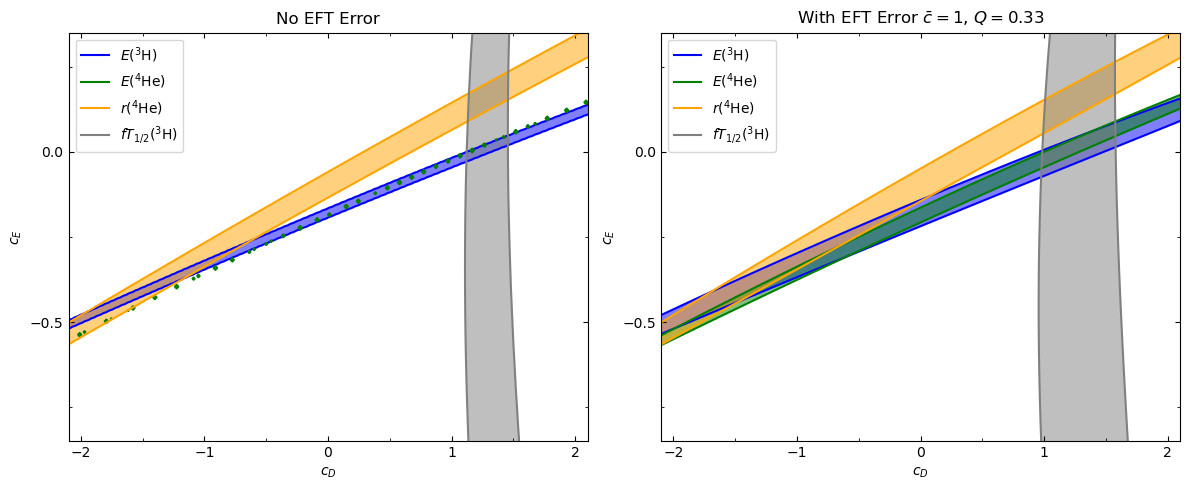

In [217]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 6a)
axs[0].set_title("No EFT Error")

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

quantities_noefterr = [pE3H_noefterr, pE4He_noefterr, pRp4He_noefterr, pfT3H_noefterr]
contour_levels_noefterr = [contour_level(quantity, 0.95) for quantity in quantities_noefterr]
colors = ['blue', 'green', 'orange', 'grey']
for quantity, level, color in zip(quantities_noefterr, contour_levels_noefterr, colors):
    axs[0].contourf(cD_eval, cE_eval, quantity, levels=[level, np.max(quantity)], colors=color, antialiased=True, alpha=0.5)
    axs[0].contour(cD_eval, cE_eval, quantity, levels=[level], colors=color, antialiased=True)

# 6b)
axs[1].set_title(r"With EFT Error $\bar{c}=1$, $Q=0.33$")

# E4He_eval: blue
# E3H_eval: green
# Rp4He_eval: orange
# fT3H_eval: grey

quantities_efterr = [pE3H_efterr, pE4He_efterr, pRp4He_efterr, pfT3H_efterr]
contour_levels_efterr = [contour_level(quantity, 0.68) for quantity in quantities_efterr]
colors = ['blue', 'green', 'orange', 'grey']
for quantity, level, color in zip(quantities_efterr, contour_levels_efterr, colors):
    axs[1].contourf(cD_eval, cE_eval, quantity, levels=[level, np.max(quantity)], colors=color, antialiased=True, alpha=0.5)
    axs[1].contour(cD_eval, cE_eval, quantity, levels=[level], colors=color, antialiased=True)

legend_labels = [
    mlines.Line2D([], [], color='blue', label='$E(^3\mathrm{H})$'),
    mlines.Line2D([], [], color='green', label='$E(^4\mathrm{He})$'),
    mlines.Line2D([], [], color='orange', label='$r(^4\mathrm{He})$'),
    mlines.Line2D([], [], color='grey', label='$fT_{1/2}(^3\mathrm{H})$')
]

for ax in axs:
    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', direction='in')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))  
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    
    ax.legend(handles=legend_labels)

    ax.set_xlim([-2.1, 2.1])
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xlabel('$c_D$')

    ax.set_ylim([-0.85, 0.35])
    ax.set_yticks([-0.5, 0])
    ax.set_ylabel('$c_E$')
    
    ax.legend(handles=legend_labels, loc="upper left")

# Adjust layout
fig.tight_layout()

fig.savefig("observable_contour_plot.png", dpi=500)
# Show the plot
plt.show()

---

## Task 2

- Perform the inference using MCMC sampling (for example using the `emcee` package) and two different choices for the combined data likelihood that includes two (or four) observables:
  - Case 1: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He})\}$
  - Case 2: $\{E(^4\mathrm{He}), R_p(^4\mathrm{He}), E(^3\mathrm{H}), fT(^3\mathrm{H})\}$
- Include the fixed EFT errors that were computed in the previous task.

- You can assume that all errors are independent, which implies that the total likelihood is just a product of the individual ones.
- Represent the results in a corner plot. I.e., you will basically reproduce the result in Fig. 3 in the paper (which is conditioned on all four observables, i.e., Case 2). Your parameter distribution will be somewhat different partly due to the fixed model discrepancy.

### Frequently used functions

MCMC sampling:

In [218]:
def mcmc(starting_guesses, nwalkers,nsteps,nburn,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Start burn-in:")
    theta, _, _ = sampler.run_mcmc(starting_guesses, nburn, progress=True)
    sampler.reset()

    print("Start sampling:")
    pos, prob, state = sampler.run_mcmc(theta, nsteps, progress=True)

    return sampler, pos, prob, state

Fit a t-distribution to data:

In [321]:
def fit_t(y, N=10000, quantile=False, confidence_level=0.86):
    mu = np.mean(y, axis=0)
    sigma = np.cov(y, rowvar=False)
    df = 2.8  
    mv_t = stats.multivariate_t(mu, sigma, df)
    if quantile:
        quantiles = [(1 - confidence_level) / 2, 1 - (1 - confidence_level) / 2]
        quantile_values = np.quantile(y, quantiles, axis=0)
        lower = quantile_values[0]
        upper = quantile_values[1]
    else:
        lower = np.min(y)
        upper = np.max(y)
    x = np.linspace(lower,upper,N)
    return (x, mv_t.pdf(x))

### Bring the data in a nicer form

In [220]:
dataset1 = [[mu_E4He, mu_Rp4He], 
            [sigma_E4He_efterr, sigma_Rp4He_efterr],
            False]

dataset2 = [[mu_E4He, mu_Rp4He, mu_E3H, mu_fT3H], 
            [sigma_E4He_efterr, sigma_Rp4He_efterr, sigma_E3H_efterr, sigma_fT3H_efterr],
            True]

### Define log_prior, log_likelihood and unnormalized posterior

In [221]:
# --- logprior ---

def log_prior(theta):
    cD, cE = theta
    prior_dist = stats.norm(0, 5)
    p1 = prior_dist.logpdf(cD)
    p2 = prior_dist.logpdf(cE)
    logprior = p1+p2
    return logprior

# --- loglikelihood ---

def log_likelihood(ytheo, mu, sigma):
    loglikelihood = stats.norm(mu, sigma).logpdf(ytheo)
    return loglikelihood

# --- logposterior ---

def log_posterior(theta, mu, sigma, full=True):
    E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(theta[0], theta[1])

    if full:
        data = [E4He_eval, Rp4He_eval, E3H_eval, fT3H_eval]
    else:
        data = [E4He_eval, Rp4He_eval]

    log_likelihoods = np.array(list(map(log_likelihood, data, mu, sigma))).sum(axis=0)
    return log_prior(theta)+log_likelihoods

In [227]:
# https://cforssen.gitlab.io/tif285-book/content/BayesianStatistics/MaxEnt/demo-MaxEnt.html
# https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial_Solution.html

ndim = 2  # number of parameters in the model
nwalkers = 20    # number of MCMC walkers
nburn = 1000     # "burn-in" period to let chains stabilize
nsteps = 2000   # number of MCMC steps to take

cD_start = 5 * np.random.rand(nwalkers,1) - 2.5 # uniform random number between -2.5 and 2.5
cE_start = 2 * np.random.rand(nwalkers,1) - 1 # uniform random number between -1. and 1.
print("cD [min,max]: ", np.min(cD_start), " | ", np.max(cD_start))
print("cE [min,max]: ", np.min(cE_start), " | ", np.max(cE_start))
starting_guesses = np.hstack((cD_start, cE_start)) # has shape (nwalkers, ndim)

cD [min,max]:  -2.408494485141735  |  2.379804274586693
cE [min,max]:  -0.931274611251562  |  0.7784697599846642


Run MCMC on the smaller dataset with fewer observations:

In [ ]:
# Runtime ~ 1 minute
sampler, _, _, _ = mcmc(starting_guesses=starting_guesses,
                   nwalkers=nwalkers,
                   nsteps=nsteps,
                   nburn=nburn,
                   ndim=ndim,
                   lnprob=log_posterior,
                   data=dataset1)

Run MCMC on the larger dataset with more oberservations:

In [224]:
# Runtime ~ 1 minute
sampler, _, _, _ = mcmc(starting_guesses=starting_guesses,
                   nwalkers=nwalkers,
                   nsteps=nsteps,
                   nburn=nburn,
                   ndim=ndim,
                   lnprob=log_posterior,
                   data=dataset2)

Start burn-in:


100%|██████████| 1000/1000 [02:44<00:00,  6.08it/s]


Start sampling:


100%|██████████| 2000/2000 [05:35<00:00,  5.96it/s]


Visualize the sampled distribution for one of the parameters:

(array([   22.,   290.,  1479.,  4750., 10113., 12174.,  7840.,  2766.,
          508.,    58.]),
 array([-0.30561323, -0.24420708, -0.18280094, -0.1213948 , -0.05998866,
         0.00141748,  0.06282362,  0.12422976,  0.1856359 ,  0.24704204,
         0.30844818]),
 [<matplotlib.patches.Polygon at 0x14ee0e2abd0>])

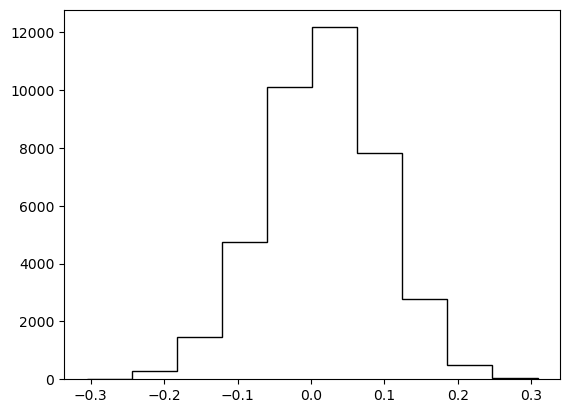

In [225]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,1], color="k", histtype="step")

* Define functions for the `log_prior`, the `log_likelihood` and the `log_posterior`. The latter is provided as input to the `emcee` sampler. Note that the likelihood (and therefore the posterior) will depend on the choice of data set.
* Operating with log probabilities, the product of independent ones turns into a simple sum.
* `scipy.stats` provides a useful library for working with continuous variable distributions and for evaluating `logpdf`.
* It is probably worthwhile to test your `log_posterior` function before starting the MCMC sampling. 
* Consider beforehand how many samples you can afford to collect.
* The `show_titles=True` option to `corner` will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.

### Reproduce corner plot in figure 3

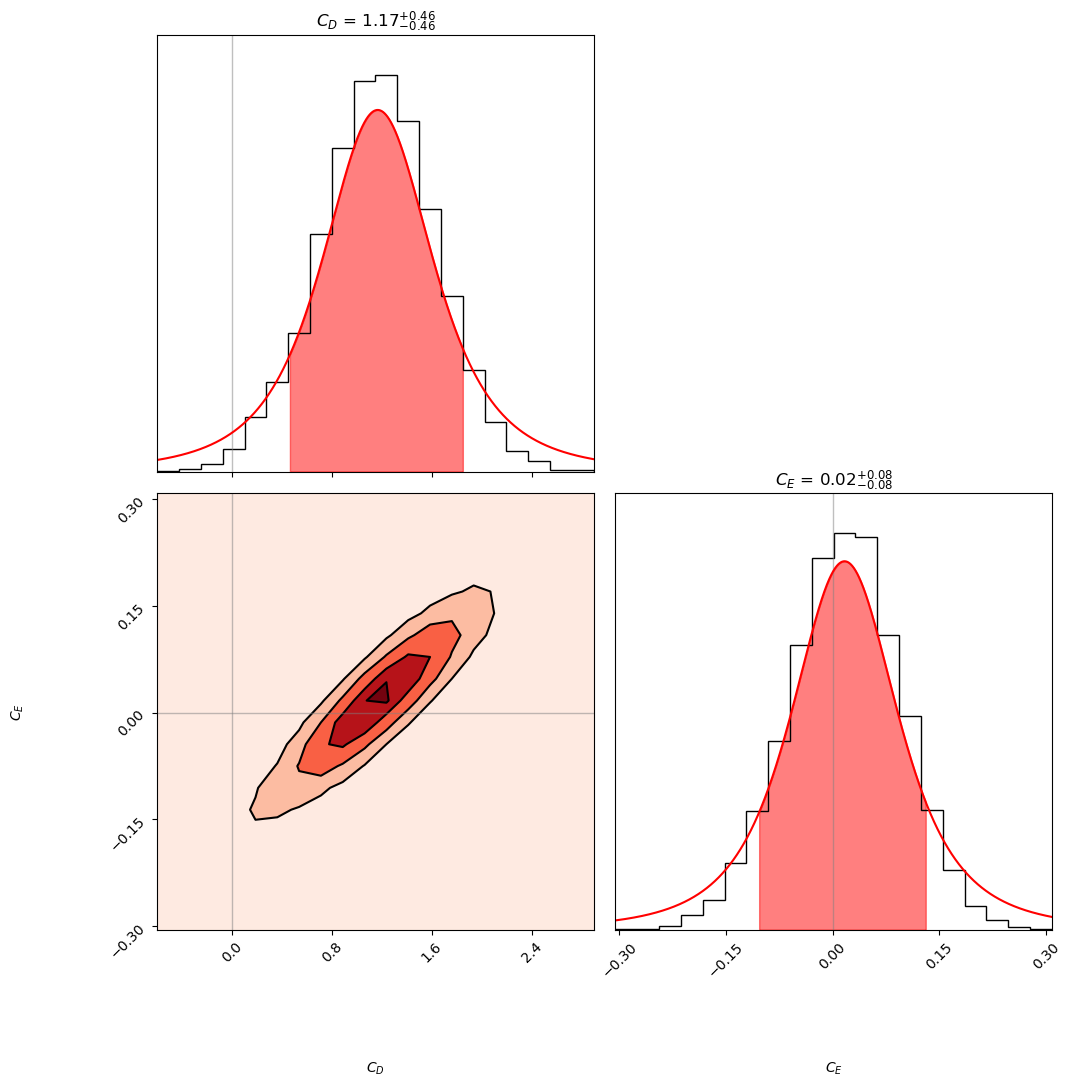

In [388]:
labels = ["$C_D$", "$C_E$"]

# Create a corner plot
figure = plt.figure(figsize=(12,12))

hist_kwargs={
    "density": True
}

contour_kwargs = {
    "colors": "black",
}

corner_kwargs={
    "plot_datapoints":False,
    "labels":labels, 
    "show_titles":True, 
    "fig":figure, 
    "smooth":0.5,
    "density": True,
    "color":"black",
    "plot_density": False,
    "fill_contours": True,
    "contourf_kwargs": {
        "cmap": "Reds",
        "colors": None
    }
}

corner.corner(samples, 
              **corner_kwargs,
              hist_kwargs=hist_kwargs, 
              contour_kwargs=contour_kwargs
              )

# Plot vertical lines for the confidence interval
for i, ax in enumerate(figure.get_axes()):
    if i==0:
        # Top left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
        
        x, y = fit_t(samples[:,0])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(samples[:,0], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==2:
        # Bottom left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
        ax.axhline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
    if i==3:
        # Bottom right
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)

        x, y = fit_t(samples[:,1])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(samples[:,1], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)        

# Show the plot
plt.show()

## Task 3

- Use samples from the posterior distribution obtained with the fulll data set (Case 2 of Task 2) and produce a posterior predictive distribution for the four observables. That is, you should reproduce a result similar to the one shown in Fig. 4.
- Represent the results in a corner plot. I.e., you will basically reproduce the result in Fig. 4 in the paper. Your results will be somewhat different partly due to the fixed model discrepancy.
- As the predicted observables are the same ones that were used for calibrating the model (i.e., entering the likelihood), this should be considered as a form of model checking. We are testing that the model is consistent and that the data analysis worked.

Reproduce figure 4

In [239]:
E4He_ppd, Rp4He_ppd, _, _, E3H_ppd, _, fT3H_ppd = vfewnucleonEmulator(samples[:,0], samples[:,1])
ppd = np.array([E3H_ppd,E4He_ppd,Rp4He_ppd,fT3H_ppd]).T

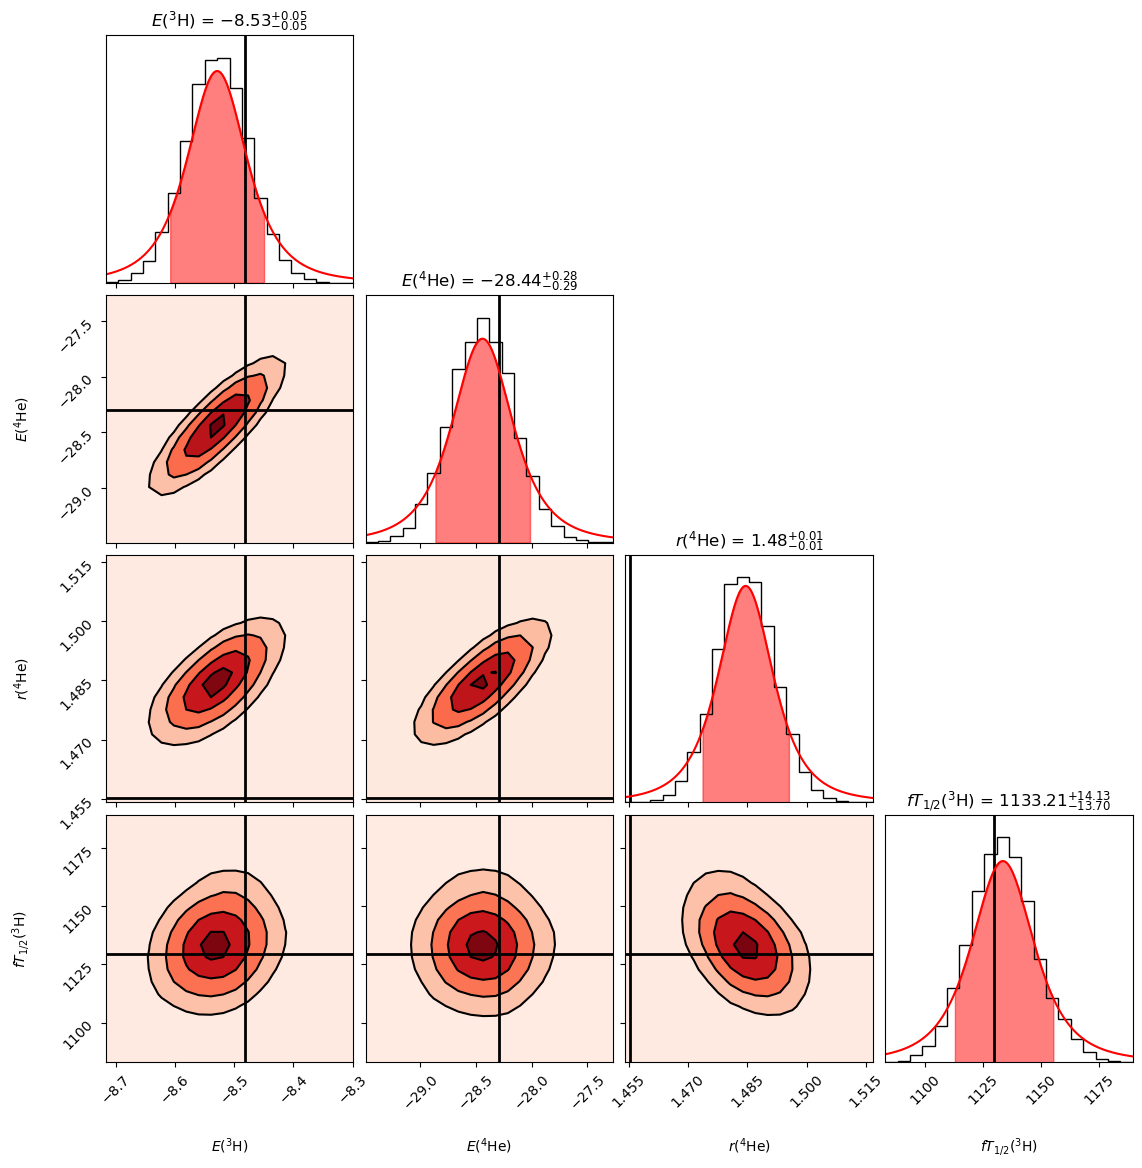

In [389]:
labels = ['$E(^3\mathrm{H})$','$E(^4\mathrm{He})$','$r(^4\mathrm{He})$','$fT_{1/2}(^3\mathrm{H})$']

# Create a corner plot
figure = plt.figure(figsize=(12,12))

hist_kwargs={
    "density": True
}

contour_kwargs = {
    "colors": "black",
}

corner_kwargs={
    "plot_datapoints":False,
    "labels":labels, 
    "show_titles":True, 
    "fig":figure, 
    "smooth":True,
    "density": True,
    "plot_density": False,
    "fill_contours": True,
    "contourf_kwargs": {
        "cmap": "Reds",
        "colors": None
    }
}

corner.corner(ppd,     
              **corner_kwargs,
              hist_kwargs=hist_kwargs, 
              contour_kwargs=contour_kwargs)

for i, ax in enumerate(figure.get_axes()):
    if i==0:
        # Marginal: E3H
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd[:,0])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd[:,0], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==5:
        # Marginal: E4He
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd[:,1])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd[:,1], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==10:
        # Marginal: Rp4He
        ax.axvline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd[:,2])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd[:,2], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==15:
        # Marginal: fT3H
        ax.axvline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd[:,3])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd[:,3], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)        
    if i==4:
        # Joined(x|y): E3H|E4He
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==8:
        # Joined(x|y): E3H|Rp4He
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==9:
        # Joined(x|y): E4He|Rp4He
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==12:
        # Joined(x|y): E3H|fT3H
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==13:
        # Joined(x|y): E4He|ft3H
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==14:
        # Joined(x|y): Rp4He|ft3H
        ax.axvline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
# Show the plot
plt.show()

## Extra Task

Assume that we would like to learn more about our error model, in particular for the model discrepancy term. Can we incorporate an uncertainty about this error in the analysis? Yes, within the bayesian framework this is relatively straightforward. For example, the expansion parameter $Q$ that enters in the variance of the model discrepancy term can be considered a model parameter. In the paper by Wesolowski et al, also the scale $\bar{c}$ was inferred but we will keep it fixed as before.

- The task is now to infer the joint posterior for $c_D, c_E, Q$ given the data and the error model ($\sigma_\mathrm{EFT}$ will not be fixed). 
- Concerning prior information for $Q$ we can use the arguments listed on page 4 in the paper and assign a weakly informative Beta distribution (with parameters $a=3$, $b=5$) for its prior. That is $p(Q|I) = B(Q | a = 3, b = 5)$.
- Try to reproduce Figs. 3 and 4 in the paper. Apart from some differences in the model parameters, the distributions should look more similar than they did in tasks 2 and 3.
- You can also glance at Fig. 5, although you are actually not varying $\bar{c}$.

In [277]:
# --- logprior ---

def log_prior_q(theta):
    cD, cE, Q = theta
    beta_dist = stats.beta(a=3,b=5)
    prior_dist = stats.norm(0, 5)
    p1 = prior_dist.logpdf(cD)
    p2 = prior_dist.logpdf(cE)
    q = beta_dist.pdf(Q)
    logprior = p1+p2+q
    return logprior

# --- logposterior ---

def log_posterior_q(theta, mu, sigma, full=True, cbar=1, k=3):
    E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(theta[0], theta[1])

    if theta[2] >= 1 or theta[2] <= 0:
        return -np.inf

    if full:
        data = [E4He_eval, Rp4He_eval, E3H_eval, fT3H_eval]

        disc2_E4He = np.power(mu[0]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        disc2_Rp4He = np.power(mu[1]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        disc2_E3H = np.power(mu[2]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        disc2_fT3H = np.power(mu[3]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        sigma_E4He_efterr = np.sqrt((sigma[0]**2)+disc2_E4He)
        sigma_Rp4He_efterr = np.sqrt((sigma[1]**2)+disc2_Rp4He)
        sigma_E3H_efterr = np.sqrt((sigma[2]**2)+disc2_E3H)
        sigma_fT3H_efterr = np.sqrt((sigma[3]**2)+disc2_fT3H)
        sigma = [sigma_E4He_efterr, sigma_Rp4He_efterr, sigma_E3H_efterr, sigma_fT3H_efterr]
    else:
        data = [E4He_eval, Rp4He_eval]

        disc2_E4He = np.power(mu[0]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        disc2_Rp4He = np.power(mu[1]*cbar*np.power(theta[2],k+1),2)/(1-(theta[2]**2))
        sigma_E4He_efterr = np.sqrt((sigma[0]**2)+disc2_E4He)
        sigma_Rp4He_efterr = np.sqrt((sigma[1]**2)+disc2_Rp4He)
        sigma = [sigma_E4He_efterr, sigma_Rp4He_efterr]

    log_likelihoods = np.array(list(map(log_likelihood, data, mu, sigma))).sum(axis=0)
    return log_prior_q(theta)+log_likelihoods

In [278]:
ndim = 3  # number of parameters in the model
nwalkers = 20    # number of MCMC walkers
nburn = 1000     # "burn-in" period to let chains stabilize
nsteps = 2000   # number of MCMC steps to take

cD_start = 5 * np.random.rand(nwalkers,1) - 2.5 # uniform random number between -2.5 and 2.5
cE_start = 2 * np.random.rand(nwalkers,1) - 1 # uniform random number between -1. and 1.
Q_start = np.random.rand(nwalkers,1) + 1e-10 # uniform random number between 0 and 1 (exclusive) -> (0,1)
print("cD [min,max]: ", np.min(cD_start), " | ", np.max(cD_start))
print("cE [min,max]: ", np.min(cE_start), " | ", np.max(cE_start))
print("Q  [min,max]: ", np.min(Q_start), " | ", np.max(Q_start))
starting_guesses = np.hstack((cD_start, cE_start, Q_start)) # has shape (nwalkers, ndim)

cD [min,max]:  -2.37667934731478  |  2.160730097473466
cE [min,max]:  -0.7944689650201349  |  0.9653033068425618
Q  [min,max]:  0.06494919767611772  |  0.9801481023629156


In [279]:
sampler_q, _, _, _ = mcmc(starting_guesses=starting_guesses,
                     nwalkers=nwalkers,
                     nsteps=nsteps,
                     nburn=nburn,
                     ndim=ndim,
                     lnprob=log_posterior_q,
                     data=dataset2)

Start burn-in:


100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]


Start sampling:


100%|██████████| 2000/2000 [06:06<00:00,  5.46it/s]


Mean:  0.28327866565863513


(array([1.1670e+03, 2.3510e+03, 5.0280e+03, 8.8300e+03, 1.2034e+04,
        7.7440e+03, 2.3970e+03, 3.8400e+02, 5.4000e+01, 1.1000e+01]),
 array([1.91047023e-04, 6.95437762e-02, 1.38896505e-01, 2.08249235e-01,
        2.77601964e-01, 3.46954693e-01, 4.16307422e-01, 4.85660152e-01,
        5.55012881e-01, 6.24365610e-01, 6.93718339e-01]),
 [<matplotlib.patches.Polygon at 0x14edf85bb50>])

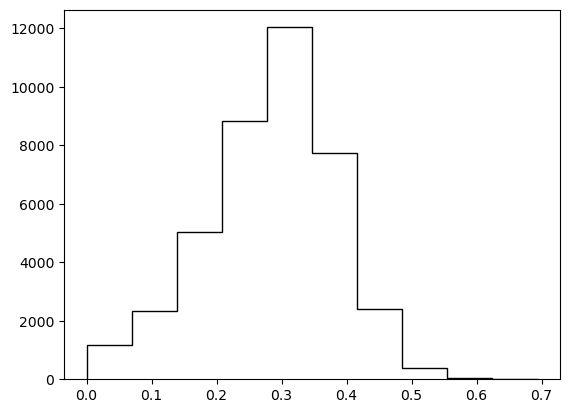

In [287]:
samples_q = sampler_q.get_chain(flat=True)
print("Mean: ", np.mean(samples_q[:,2]))
plt.hist(samples_q[:,2], color="k", histtype="step")

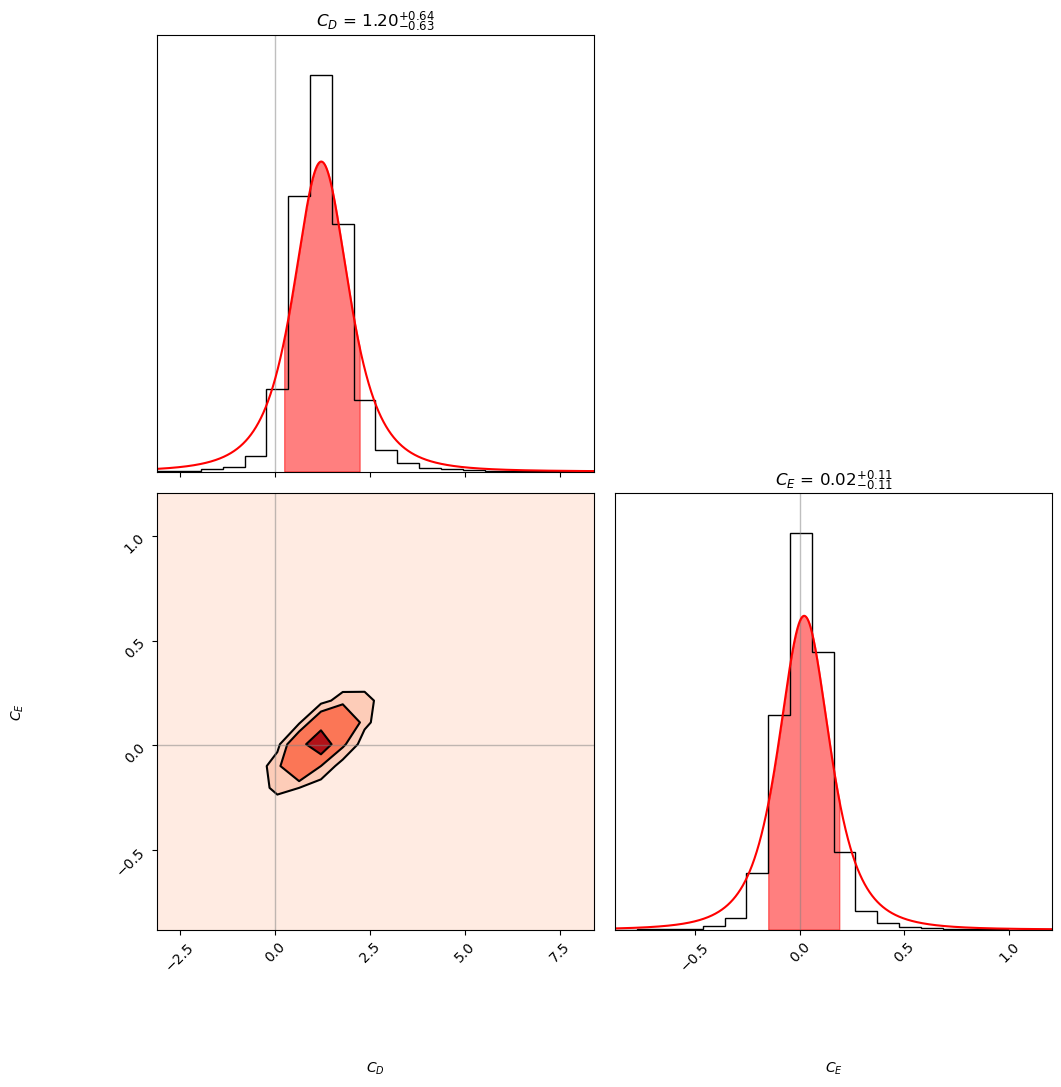

In [387]:
labels = ["$C_D$", "$C_E$"]

# Create a corner plot
figure = plt.figure(figsize=(12,12))

hist_kwargs={
    "density": True
}

contour_kwargs = {
    "colors": "black",
}

corner_kwargs={
    "plot_datapoints":False,
    "labels":labels, 
    "show_titles":True, 
    "fig":figure, 
    "smooth":0.5,
    "density": True,
    "plot_density": False,
    "fill_contours": True,
    "contourf_kwargs": {
        "cmap": "Reds",
        "colors": None
    }
}

corner.corner(samples_q[:,0:2],               
              **corner_kwargs,
              hist_kwargs=hist_kwargs, 
              contour_kwargs=contour_kwargs
              )

for i, ax in enumerate(figure.get_axes()):
    if i==0:
        # Top left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
        
        x, y = fit_t(samples_q[:,0])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(samples_q[:,0], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==2:
        # Bottom left
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
        ax.axhline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)
    if i==3:
        # Bottom right
        ax.axvline(0, color='grey', linestyle='-', linewidth=1, alpha=.5)

        x, y = fit_t(samples_q[:,1])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(samples_q[:,1], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)        

# Show the plot
plt.show()

In [290]:
E4He_ppd, Rp4He_ppd, _, _, E3H_ppd, _, fT3H_ppd = vfewnucleonEmulator(samples_q[:,0], samples_q[:,1])
ppd_q = np.array([E3H_ppd,E4He_ppd,Rp4He_ppd,fT3H_ppd]).T

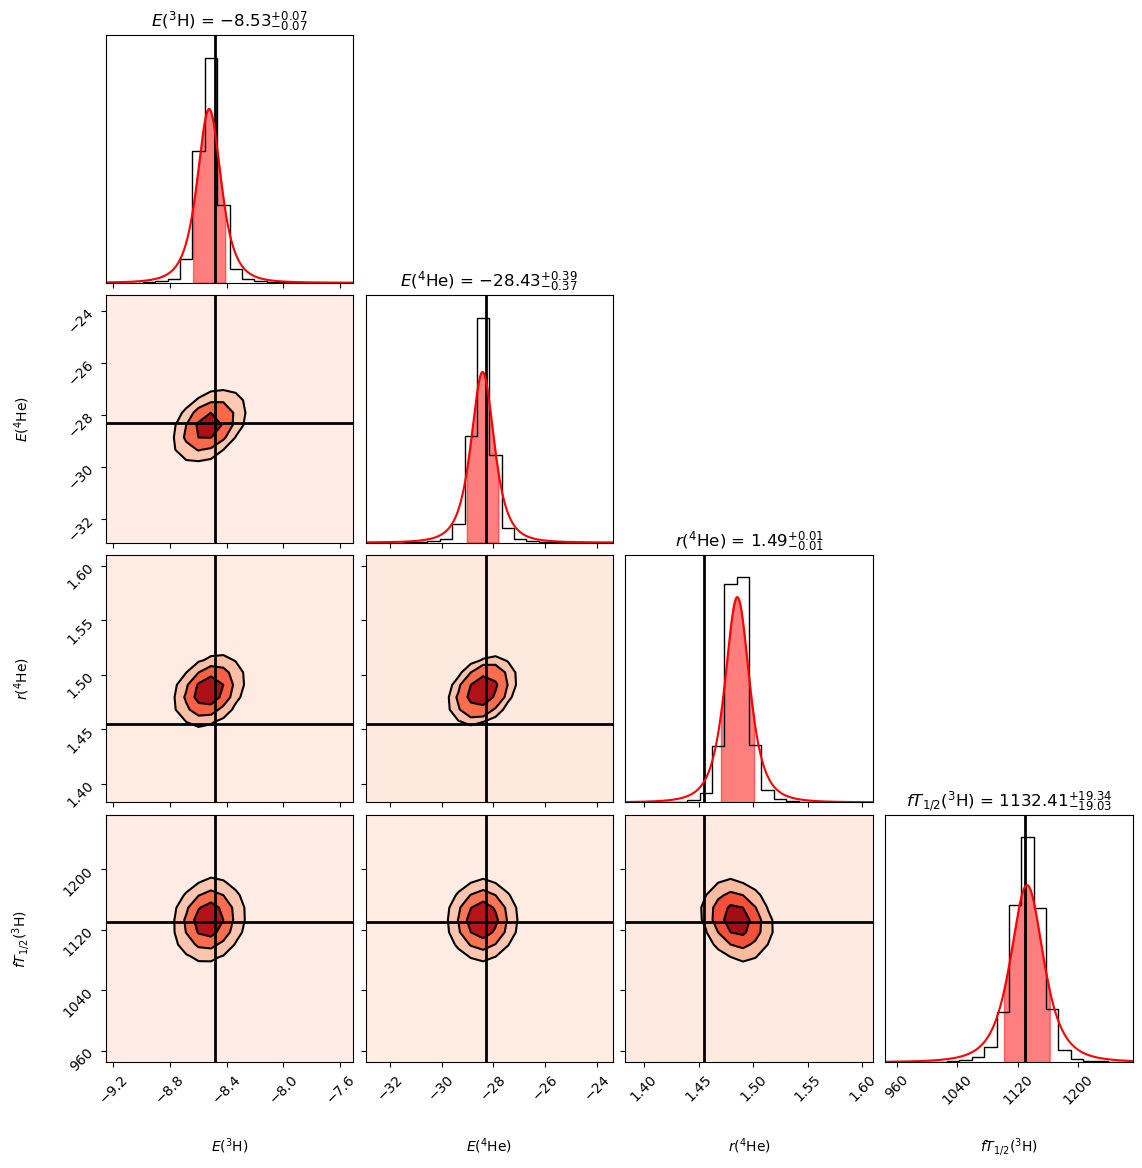

In [390]:
labels = ['$E(^3\mathrm{H})$','$E(^4\mathrm{He})$','$r(^4\mathrm{He})$','$fT_{1/2}(^3\mathrm{H})$']

# Create a corner plot
figure = plt.figure(figsize=(12,12))

hist_kwargs={
    "density": True
}

contour_kwargs = {
    "colors": "black",
}

corner_kwargs={
    "plot_datapoints":False,
    "labels":labels, 
    "show_titles":True, 
    "fig":figure, 
    "smooth":True,
    "density": True,
    "plot_density": False,
    "fill_contours": True,
    "contourf_kwargs": {
        "cmap": "Reds",
        "colors": None
    }
}

corner.corner(ppd_q,               
              **corner_kwargs,
              hist_kwargs=hist_kwargs, 
              contour_kwargs=contour_kwargs
              )

for i, ax in enumerate(figure.get_axes()):
    if i==0:
        # Marginal: E3H
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd_q[:,0])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd_q[:,0], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==5:
        # Marginal: E4He
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd_q[:,1])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd_q[:,1], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==10:
        # Marginal: Rp4He
        ax.axvline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd_q[:,2])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd_q[:,2], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)
    if i==15:
        # Marginal: fT3H
        ax.axvline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)

        x, y = fit_t(ppd_q[:,3])
        ax.plot(x, y, color="red")

        x_quant, y_quant = fit_t(ppd_q[:,3], quantile=True)
        ax.fill_between(x_quant, y_quant, color="red", alpha=0.5)        
    if i==4:
        # Joined(x|y): E3H|E4He
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==8:
        # Joined(x|y): E3H|Rp4He
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==9:
        # Joined(x|y): E4He|Rp4He
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==12:
        # Joined(x|y): E3H|fT3H
        ax.axvline(mu_E3H, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==13:
        # Joined(x|y): E4He|ft3H
        ax.axvline(mu_E4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
    if i==14:
        # Joined(x|y): Rp4He|ft3H
        ax.axvline(mu_Rp4He, color='black', linestyle='-', linewidth=2, alpha=1)
        ax.axhline(mu_fT3H, color='black', linestyle='-', linewidth=2, alpha=1)
# Show the plot
plt.show()